<a href="https://colab.research.google.com/github/lyeonsl/2025-Beyond-Summer-Project_library_seat_detection/blob/main/2025_Beyond_Summer_Project_Pre_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4주차(비대면) - 라벨링한 Dataset Yolov8 학습
### Dataset : chair-occupied-dataset
>

### 0. zip 파일 업로드



In [ ]:
from google.colab import files
uploaded = files.upload()  # zip 파일 업로드

Saving chair_occupied_dataset.zip to chair_occupied_dataset.zip


### 1. 압축 해제 및 경로 준비

In [ ]:
# 압축 해제
import zipfile
import os

zip_path = "chair_occupied_dataset.zip"
extract_path = "/content/chair_occupied_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# data.yaml 경로 확인
yaml_path = os.path.join(extract_path, "-unoccupied-1", "data.yaml")
print("data.yaml 위치:", yaml_path)


data.yaml 위치: /content/chair_occupied_dataset/-unoccupied-1/data.yaml


### 2. YOLOv8 설치 및 모델 로드

In [ ]:
# ultralytics 설치
!pip install ultralytics

# 모델 로드
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # 경량 모델 (또는 yolov8s.pt 등 가능)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

100%|██████████| 6.25M/6.25M [00:00<00:00, 105MB/s]


### 3. 학습 실행

In [ ]:
# 모델 학습 시작
model.train(
    data=yaml_path,        # data.yaml 경로
    epochs=50,
    imgsz=640,
    batch=16,
    name="yolov8_chair"
)

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/chair_occupied_dataset/-unoccupied-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_chair, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 100MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.9±5.7 MB/s, size: 34.0 KB)


train: Scanning /content/chair_occupied_dataset/-unoccupied-1/train/labels... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:01<00:00, 572.23it/s]

train: /content/chair_occupied_dataset/-unoccupied-1/train/images/A60_png_jpg.rf.711cca46646a907c69977776c8144196.jpg: 1 duplicate labels removed
train: New cache created: /content/chair_occupied_dataset/-unoccupied-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8.8±4.0 MB/s, size: 32.9 KB)


val: Scanning /content/chair_occupied_dataset/-unoccupied-1/valid/labels... 275 images, 0 backgrounds, 0 corrupt: 100%|██████████| 275/275 [00:00<00:00, 539.30it/s]

val: /content/chair_occupied_dataset/-unoccupied-1/valid/images/frames2_frame_464_jpg.rf.448c7f7287a35cc84b12feb0e7a736f0.jpg: 1 duplicate labels removed
val: New cache created: /content/chair_occupied_dataset/-unoccupied-1/valid/labels.cache


Plotting labels to runs/detect/yolov8_chair/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_chair
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         2G      1.315      2.196      1.645         70        640: 100%|██████████| 60/60 [00:17<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

                   all        275        653      0.713      0.342      0.451      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.48G      1.368      1.794      1.671         89        640: 100%|██████████| 60/60 [00:15<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


                   all        275        653      0.477       0.46      0.474      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.48G      1.431      1.728      1.713         75        640: 100%|██████████| 60/60 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


                   all        275        653      0.421      0.411      0.376       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.48G      1.423      1.715       1.71         78        640: 100%|██████████| 60/60 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


                   all        275        653      0.554      0.481      0.508      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.5G      1.429      1.684      1.723         48        640: 100%|██████████| 60/60 [00:15<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        275        653      0.407      0.576      0.442      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.5G      1.374      1.549      1.663         45        640: 100%|██████████| 60/60 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        275        653      0.639      0.583      0.648      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.5G      1.346      1.491      1.647         69        640: 100%|██████████| 60/60 [00:15<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]

                   all        275        653      0.721      0.706      0.765      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.51G      1.309      1.401      1.617         51        640: 100%|██████████| 60/60 [00:14<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]

                   all        275        653       0.75      0.618       0.72      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.52G      1.297      1.382      1.613         56        640: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

                   all        275        653      0.795      0.722      0.809       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.53G      1.283       1.35       1.59         78        640: 100%|██████████| 60/60 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

                   all        275        653      0.788      0.712        0.8      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.53G      1.284      1.325      1.587         71        640: 100%|██████████| 60/60 [00:14<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

                   all        275        653      0.769      0.719      0.792       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.53G      1.253      1.267      1.561         69        640: 100%|██████████| 60/60 [00:15<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        275        653      0.773      0.672      0.756      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.55G      1.224      1.241      1.543         79        640: 100%|██████████| 60/60 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.19it/s]

                   all        275        653      0.815      0.712      0.812      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.55G      1.212      1.235      1.518         81        640: 100%|██████████| 60/60 [00:15<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all        275        653      0.834      0.757      0.847      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.56G      1.201      1.187      1.528         68        640: 100%|██████████| 60/60 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        275        653      0.819      0.745      0.838      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.57G      1.168      1.147      1.506         60        640: 100%|██████████| 60/60 [00:14<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

                   all        275        653      0.839      0.751      0.833        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.58G      1.165      1.173      1.501         81        640: 100%|██████████| 60/60 [00:16<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        275        653      0.826      0.767      0.854      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.58G      1.158      1.146      1.488         89        640: 100%|██████████| 60/60 [00:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

                   all        275        653      0.804      0.731      0.839      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.58G      1.147      1.092       1.48         65        640: 100%|██████████| 60/60 [00:15<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all        275        653      0.895      0.785      0.883       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.58G      1.129      1.084      1.472         80        640: 100%|██████████| 60/60 [00:15<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        275        653      0.832      0.803      0.889      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.58G      1.116      1.062      1.451         55        640: 100%|██████████| 60/60 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        275        653      0.823      0.817      0.877      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.58G      1.103       1.03       1.45         70        640: 100%|██████████| 60/60 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]

                   all        275        653       0.85      0.803      0.889      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.58G      1.069      1.005      1.425         68        640: 100%|██████████| 60/60 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]

                   all        275        653       0.89      0.815      0.896      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.58G      1.068      1.027      1.432         68        640: 100%|██████████| 60/60 [00:16<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        275        653      0.853      0.823      0.901      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.58G       1.08      1.005       1.42         77        640: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        275        653      0.859       0.86      0.912      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.58G      1.049     0.9634      1.402         80        640: 100%|██████████| 60/60 [00:15<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


                   all        275        653      0.867       0.86      0.917      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.58G      1.066     0.9786      1.409         98        640: 100%|██████████| 60/60 [00:15<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

                   all        275        653      0.889      0.857      0.913      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.58G      1.027     0.9531      1.403         70        640: 100%|██████████| 60/60 [00:15<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.10it/s]

                   all        275        653      0.877      0.847      0.918       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.58G     0.9978     0.9061      1.371         69        640: 100%|██████████| 60/60 [00:16<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        275        653      0.885      0.832      0.916      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.58G      1.004     0.9142       1.37         72        640: 100%|██████████| 60/60 [00:15<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        275        653      0.884      0.858      0.923       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.58G      1.013     0.8858      1.378         60        640: 100%|██████████| 60/60 [00:15<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        275        653      0.891      0.844      0.914      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.58G     0.9954     0.8883      1.372         79        640: 100%|██████████| 60/60 [00:15<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        275        653      0.863      0.864      0.919      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.58G     0.9529     0.8603      1.334         46        640: 100%|██████████| 60/60 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]

                   all        275        653      0.889      0.862      0.929      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.58G     0.9772      0.862      1.354         79        640: 100%|██████████| 60/60 [00:15<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

                   all        275        653      0.912      0.861      0.934      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.58G     0.9613     0.8715      1.341         72        640: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        275        653      0.884      0.833      0.921      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.58G     0.9497       0.84      1.344         62        640: 100%|██████████| 60/60 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        275        653      0.907      0.865      0.927      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.58G     0.9421      0.822       1.33         55        640: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

                   all        275        653      0.866      0.897       0.93      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.58G     0.9291     0.8133      1.329         48        640: 100%|██████████| 60/60 [00:15<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

                   all        275        653       0.89       0.89       0.94      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.58G      0.935     0.8285      1.315         87        640: 100%|██████████| 60/60 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        275        653      0.901      0.881      0.935      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.58G     0.9094      0.788      1.304         78        640: 100%|██████████| 60/60 [00:15<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]

                   all        275        653      0.909      0.872      0.938      0.663


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.58G     0.8241     0.6491      1.298         37        640: 100%|██████████| 60/60 [00:16<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]

                   all        275        653        0.9      0.883      0.945      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.58G     0.8002      0.604      1.291         23        640: 100%|██████████| 60/60 [00:14<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        275        653      0.906      0.887      0.945      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.58G      0.765     0.5866      1.251         40        640: 100%|██████████| 60/60 [00:14<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all        275        653      0.914      0.889      0.948       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.58G     0.7718     0.5677      1.262         26        640: 100%|██████████| 60/60 [00:14<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        275        653      0.915       0.87      0.945      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.58G      0.756     0.5506      1.252         49        640: 100%|██████████| 60/60 [00:14<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]

                   all        275        653       0.91      0.902       0.95       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.58G     0.7241     0.5378      1.234         42        640: 100%|██████████| 60/60 [00:14<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

                   all        275        653      0.915      0.909      0.952      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.58G     0.7052     0.5297      1.202         39        640: 100%|██████████| 60/60 [00:14<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        275        653      0.917      0.888      0.949      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.58G     0.7045     0.5152      1.208         40        640: 100%|██████████| 60/60 [00:14<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        275        653      0.915      0.898      0.954      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.58G     0.6931     0.5147      1.199         27        640: 100%|██████████| 60/60 [00:14<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]

                   all        275        653      0.887      0.912      0.953      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.58G     0.6685     0.4986      1.174         30        640: 100%|██████████| 60/60 [00:14<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]

                   all        275        653      0.914      0.894      0.954      0.699



50 epochs completed in 0.251 hours.
Optimizer stripped from runs/detect/yolov8_chair/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_chair/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_chair/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]


                   all        275        653      0.915      0.894      0.954      0.699
            unoccupied        215        456        0.9      0.864      0.934       0.67
              occupied        110        197       0.93      0.924      0.975      0.727
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8_chair


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cb39f0c5750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

### 4. 학습된 모델로 예측 확인

In [ ]:
import glob

# 이미지 폴더 경로
image_folder = "/content/chair_occupied_dataset/-unoccupied-1/valid/images"

# 이미지 확장자 확인
image_files = glob.glob(image_folder + "/*.jpg") + glob.glob(image_folder + "/*.png")

print(f"총 {len(image_files)}개의 이미지 파일이 있습니다.")
for f in image_files[:10]:  # 처음 10개만 출력
    print(f)

총 275개의 이미지 파일이 있습니다.
/content/chair_occupied_dataset/-unoccupied-1/valid/images/Chair-40-_jpg.rf.ce93ca315f5dc166afcf2d28a1e1e36c.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/Screenshot-2022-08-09-104431_jpg.rf.9bcad4d11c0862a59c0a4b2c66d82411.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/cadeira-de-escritorio-azul_mp4-91_jpg.rf.bc02a42333821f40cd8ad22bad42787d.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/138_png_jpg.rf.1dc8eb447c1044a64baa2720a60f6d1f.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/155_png_jpg.rf.66ec354abe98645a05980b35703a9a26.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/167_png_jpg.rf.3d8937fb9b4b7d70c2fe87962faa387f.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/frames3_frame_232_jpg.rf.c396d56b6802ea14154fbf40f0fe4422.jpg
/content/chair_occupied_dataset/-unoccupied-1/valid/images/Screenshot-from-2022-07-18-00-38-20_jpg.rf.ee7293e06910697d7ead36d916cb7c03.jpg
/co


0: 640x640 1 occupied, 9.2ms
Speed: 1.8ms preprocess, 9.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


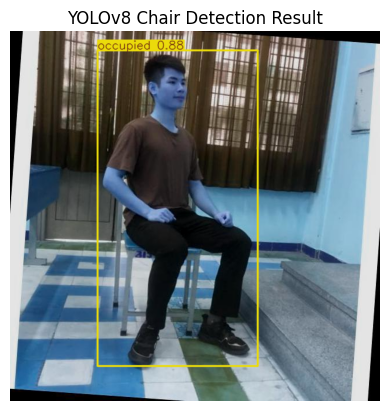

탐지된 박스 수: 1
박스 정보: tensor([[151.2560,  33.0180, 428.0820, 579.8170]], device='cuda:0')
클래스 정보: tensor([1.], device='cuda:0')
신뢰도: tensor([0.8769], device='cuda:0')


In [ ]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# 1. 모델 불러오기
model = YOLO('/content/runs/detect/yolov8_chair/weights/best.pt')  # 경로 확인 필요

# 2. 이미지 불러오기
image_path = '/content/chair_occupied_dataset/-unoccupied-1/valid/images/Screenshot-2022-08-09-104548_jpg.rf.8b2d8db8eefd84a7a76b0d29f9c7d607.jpg'
image = Image.open(image_path)

# 3. 예측 실행
results = model(image, conf=0.1)  # conf 낮춰보기

# 4. 결과 이미지 시각화
res_plotted = results[0].plot()  # 바운딩 박스가 그려진 이미지 (numpy 배열)

# 5. 이미지 출력
plt.imshow(res_plotted)
plt.axis('off')
plt.title("YOLOv8 Chair Detection Result")
plt.show()

# 6. 결과 출력 (박스가 실제로 있는지 확인)
print("탐지된 박스 수:", len(results[0].boxes))
print("박스 정보:", results[0].boxes.xyxy)
print("클래스 정보:", results[0].boxes.cls)
print("신뢰도:", results[0].boxes.conf)

In [ ]:
print(model.names)

{0: 'unoccupied', 1: 'occupied'}


In [ ]:
# 예측된 바운딩 박스 정보 출력
for box in results[0].boxes:
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    xyxy = box.xyxy[0].tolist()
    print(f"Class: {model.names[cls]}, Conf: {conf:.2f}, BBox: {xyxy}")

Class: occupied, Conf: 0.88, BBox: [151.2560272216797, 33.01800537109375, 428.08197021484375, 579.8169555664062]


### 5. Valid 세트 테스트


image 1/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/07_PNG.rf.ea33319c09e452d2b322085c545b1dea.jpg: 640x640 1 unoccupied, 19.8ms
image 2/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/100_png_jpg.rf.07d9021b1abf9c84766f2ed9d8131df2.jpg: 640x640 2 unoccupieds, 10.0ms
image 3/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/100_png_jpg.rf.102c28416f286bd1fa6f43867b3d277f.jpg: 640x640 2 unoccupieds, 8.3ms
image 4/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/104_png_jpg.rf.4e9057e5392606428bd79f09812c0ba4.jpg: 640x640 3 unoccupieds, 8.5ms
image 5/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/105_png_jpg.rf.49933bd29c746aae242dd5514f3136b5.jpg: 640x640 1 unoccupied, 8.3ms
image 6/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/105_png_jpg.rf.81f7fb1fef3c29c0b10bc3beb70d69b7.jpg: 640x640 1 unoccupied, 8.3ms
image 7/275 /content/chair_occupied_dataset/-unoccupied-1/valid/images/105_png_jpg.rf.9

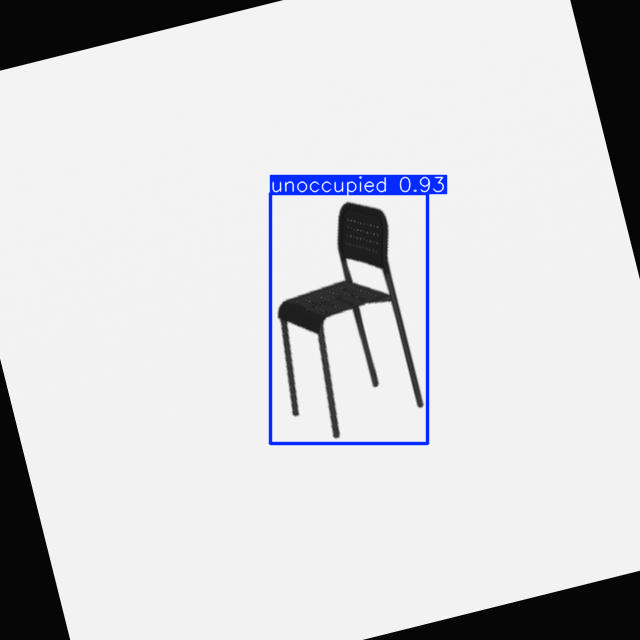

In [ ]:
# 검출 실행 (validation 이미지 대상)
val_images_path = os.path.join(extract_path, "-unoccupied-1", "valid", "images")

results = model.predict(
    source=val_images_path,
    conf=0.3,
    save=True
)

# 시각화 결과 보기
results[0].show()


### 6. Test 세트 테스트